In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
%matplotlib

loc = 'workstation'
if loc == 'laptop':
    #eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/student_projects/EffortDifficulty/analysis/tools'
    eyefuncdir = '/Users/sammichekroud/Desktop/postdoc/tools'
    wd         = '/Users/sammichekroud/Desktop/postdoc/wmconfidence' #working on confidence data, but in postdoc dir
elif loc == 'workstation':
    eyefuncdir = 'C:/Users/sammirc/Desktop/postdoc/tools/'
    wd         =  'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
    funcdir    = op.join(wd, 'analysis', 'tools')
    sys.path.insert(0, funcdir)
os.chdir(wd)
sys.path.insert(0, eyefuncdir)
import eyefuncs as eyes
from funcs import clusterperm_test

eyedir = op.join(wd, 'data', 'eyes')
bdir   = op.join(wd, 'data', 'datafiles')

subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]) #all ppts
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26]) #good eeg
subs = np.array([         4, 5, 6, 7, 8, 9,             13, 14, 15,     17,         20, 21, 22,     24, 25, 26]) # good eeg and eyetracking
nsubs = subs.size

#set some params here
modeltimes = np.round(np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy')), 2)
eegtimes   = np.round(np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm3_evidence', 'eeg_times.npy')), 2)
regnames   = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm3_evidence', 'regressor_names.npy'))
nparams = regnames.size

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [2]:
logdata = True
if logdata:
    logtxt = '_logpower'
else:
    logtxt = ''

b = np.zeros(shape = [nsubs, nparams, modeltimes.size, eegtimes.size]) * np.nan
t = np.zeros_like(b) * np.nan
subcount = -1
for sub in subs:
    subcount += 1
    ib = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm3_evidence', f'wmc_s{sub:02d}_glm3{logtxt}_betas.npy'))
    it = np.load(op.join(wd, 'data', 'glms', 'eeg', 'glm3_evidence', f'wmc_s{sub:02d}_glm3{logtxt}_tvalues.npy'))
    b[subcount] = ib.copy()
    t[subcount] = it.copy()
bm = np.nanmean(b, axis=0) #average across participants
tm = np.nanmean(t, axis=0) #average t-values across participants

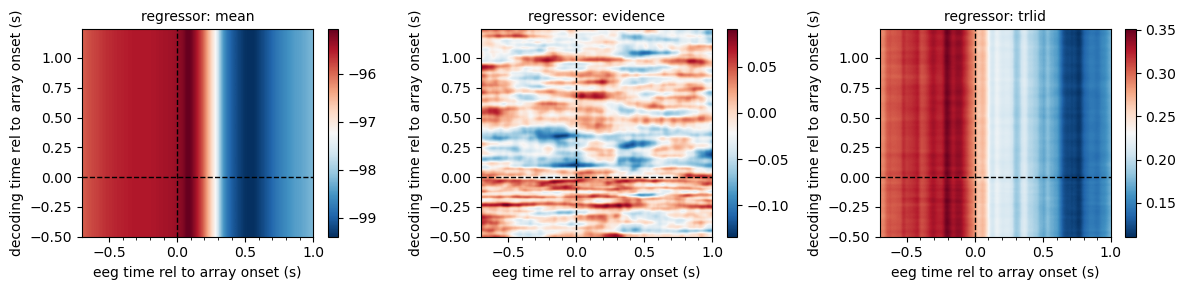

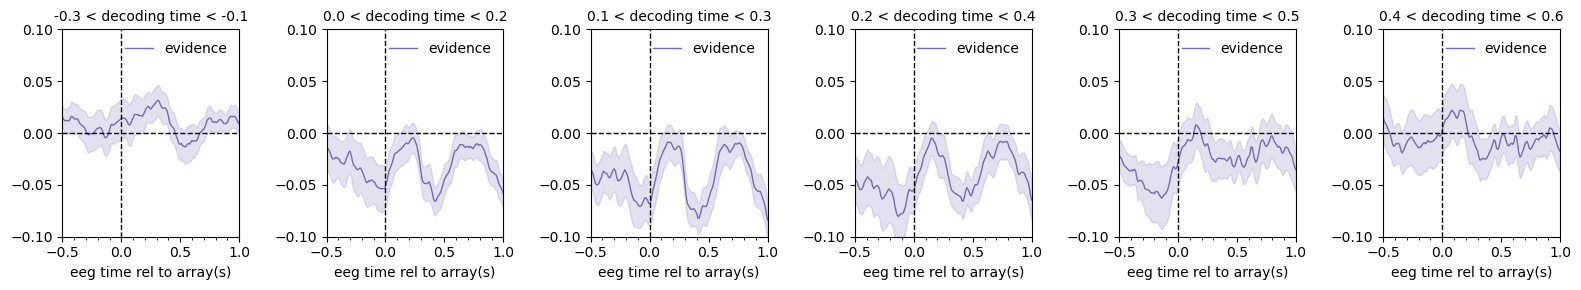

In [3]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -600, 600
        vmin, vmax = None, None
    else:
        vmin, vmax = -10, 10 
        vmin, vmax = None, None
        
    ax = fig.add_subplot(1, nparams, iparam+1)
    plot = ax.imshow(bm[iparam].squeeze(), aspect= 'auto', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xlabel('eeg time rel to array onset (s)')
    ax.set_ylabel('decoding time rel to array onset (s)')
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = b[:,:, tinds].mean(axis=2) #average across time window
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(1):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < decoding time < {iend}', fontsize = 10)
    
    ax.set_ylim([-0.1, 0.1]) #
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('eeg time rel to array(s)', fontsize = 10)
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout()

stat_fun(H1): min=-2.555119439647304 max=0.5085054550884622
Running initial clustering …
Found 2 clusters


C:\Users\sammirc\anaconda3\envs\mne\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 65534/65534 [00:04<00:00, 13558.21it/s]


cluster p-values for evidence regressor: [0.52722972 0.08213931]
stat_fun(H1): min=-3.289145931826281 max=0.7230447582374433
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 30342.97it/s]


cluster p-values for evidence regressor: [0.06582742 0.04406806]
stat_fun(H1): min=-2.8447786845378316 max=0.6594425507220577
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 26182.11it/s]


cluster p-values for evidence regressor: [0.42009613 0.02322423]


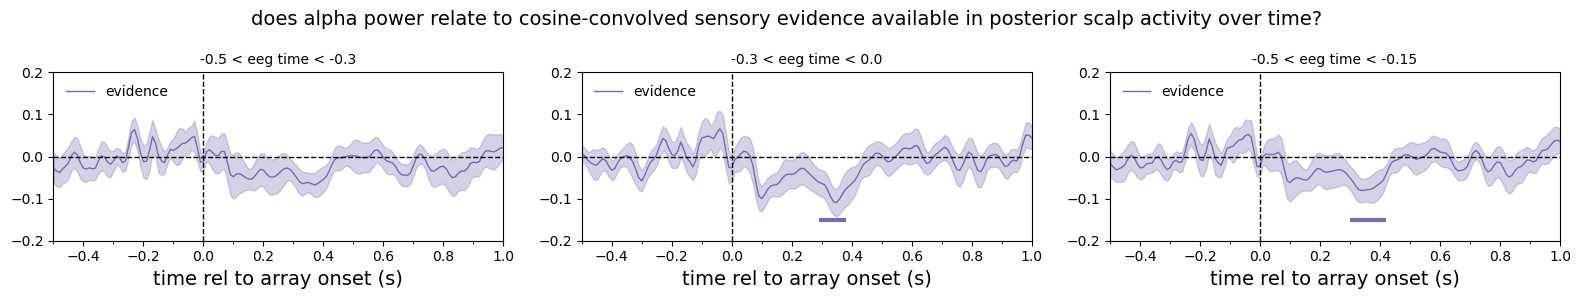

In [4]:
#params for cluster forming
alpha = 0.05
df = nsubs
t_thresh = sp.stats.t.ppf(1-alpha, df = df)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing

mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0, -0.15]

nplots = len(mstarts)
cols = ['#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    plotd = b[:,:,:, tinds].mean(-1) #average across pupil timw window
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(1):
        ax.plot(modeltimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < eeg time < {iend}', fontsize = 10)
    ax.set_ylim([-0.2, 0.2])
    ax.set_xlim([-0.3, 0.75])
    ax.set_xticks(np.arange(-0.5, 1.1, 0.1), minor=True)
    ax.set_xlabel('time rel to array onset (s)', fontsize = 14)

    #run cluster permutation stats
    idat = dict(regressor = plotd[:,iplot].copy()) #function expects a dictionary
    tv, clu, clupv, _ = clusterperm_test(data = plotd,
                                    labels = regnames, of_interest = 'evidence', times = modeltimes,
                                    tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = 'all', #run all possible permutations (exact permutation test)
                                    threshold = -t_thresh, tail = -1, #two-tailed for now
                                    n_jobs=4)
    clu = [x[0] for x in clu]
    print(f'cluster p-values for evidence regressor: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= alpha:
            itmin = times_twin[mask[0]]
            itmax = times_twin[mask[-1]]
            ax.hlines(y = -0.15, xmin = itmin, xmax = itmax, lw = 3, color = cols[ireg], alpha = 1)
    
    ax.legend(loc = 'upper left', frameon=False)
fig.suptitle('does alpha power relate to cosine-convolved sensory evidence available in posterior scalp activity over time?', fontsize=14)
fig.tight_layout()

<font color='red'>

same pipeline but using single-subject t-values instead of beta weights (scales the within-participant effect by variance in the effect)

<bound method Figure.tight_layout of <Figure size 1600x300 with 6 Axes>>

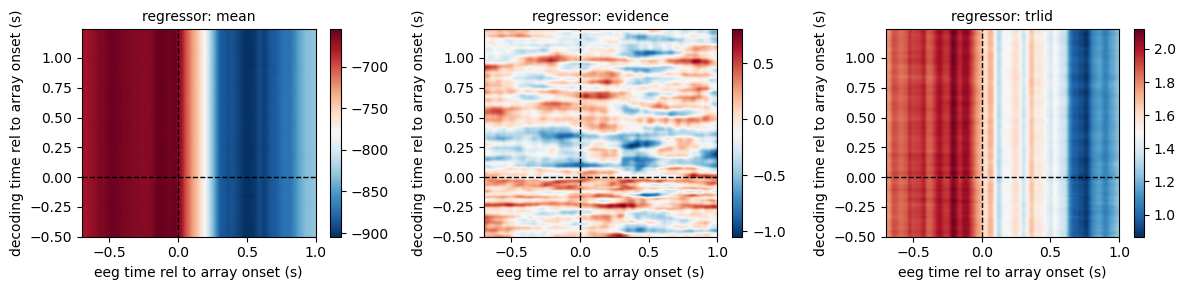

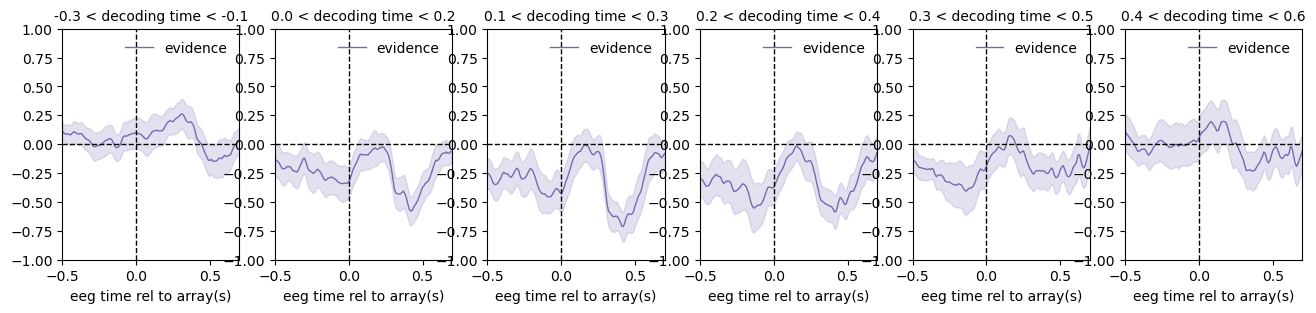

In [5]:
fig = plt.figure(figsize = [12, 3])
for iparam in range(nparams):
    if iparam == 0:
        vmin, vmax = -600, 600
        vmin, vmax = None, None
    else:
        vmin, vmax = -10, 10 
        vmin, vmax = None, None
        
    ax = fig.add_subplot(1, nparams, iparam+1)
    plot = ax.imshow(tm[iparam].squeeze(), aspect= 'auto', interpolation='gaussian', cmap='RdBu_r', origin = 'lower',
                     vmin = vmin, vmax = vmax, 
                     extent = [eegtimes.min(), eegtimes.max(), modeltimes.min(), modeltimes.max()])
    ax.set_title(f'regressor: {regnames[iparam]}', fontsize = 10)
    ax.set_xlabel('eeg time rel to array onset (s)')
    ax.set_ylabel('decoding time rel to array onset (s)')
    ax.axvline(0, ls = 'dashed', color = 'k', lw = 1)
    ax.axhline(0, ls = 'dashed', color = 'k', lw = 1)
    fig.colorbar(plot)
fig.tight_layout()

mstarts = [-0.3, 0.0, 0.1, 0.2, 0.3, 0.4]
mends   = [-0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nplots = len(mstarts)
cols = ['#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(modeltimes >= istart, modeltimes <= iend)
    plotd = t[:,:, tinds].mean(axis=2) #average across time window
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(1):
        ax.plot(eegtimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(eegtimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.2, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < decoding time < {iend}', fontsize = 10)
    
    ax.set_ylim([-1, 1]) #
    ax.set_xlim([-0.5, 0.7])
    ax.set_xlabel('eeg time rel to array(s)', fontsize = 10)
    ax.legend(loc = 'upper right', frameon=False)
fig.tight_layout

stat_fun(H1): min=-2.440832315881191 max=0.7184284963101206
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 25863.23it/s]


cluster p-values for evidence regressor: [0.56317998 0.08793774 0.69608606]
stat_fun(H1): min=-3.309799504460371 max=1.141524682662867
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 24299.43it/s]


cluster p-values for evidence regressor: [0.09158465 0.0481117 ]
stat_fun(H1): min=-2.763625837203961 max=0.9638375643049794
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 65534/65534 [00:02<00:00, 26310.16it/s]


cluster p-values for evidence regressor: [0.54161898 0.02897688]


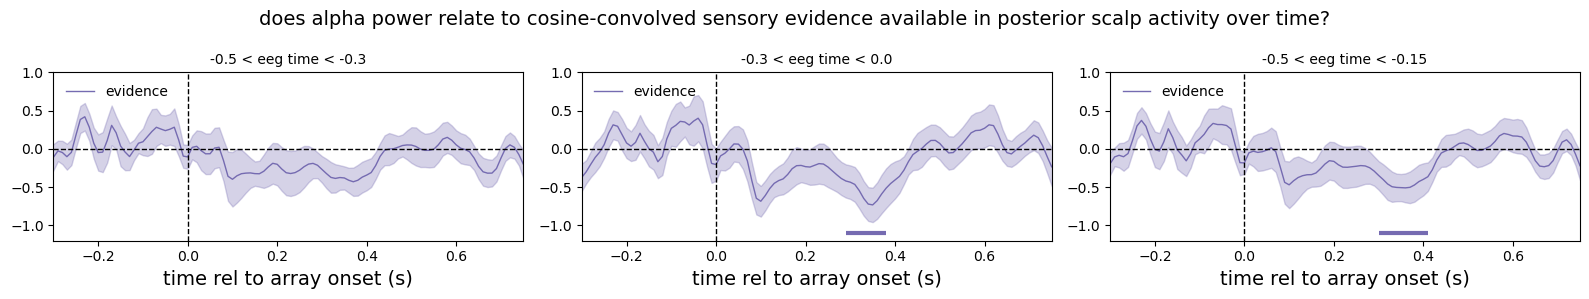

In [6]:
#params for cluster forming
alpha = 0.05
df = nsubs
t_thresh = sp.stats.t.ppf(1-alpha, df = df)
tmin, tmax = 0, 0.75 #time-window for cluster permutation testing

mstarts = [-0.5, -0.3, -0.5]
mends   = [-0.3,  0.0, -0.15]

nplots = len(mstarts)
cols = ['#756bb1']
fig = plt.figure(figsize = [16, 3])
for iplot, istart, iend in zip(range(nplots), mstarts, mends):
    # print(iplot, istart, iend)
    ax = fig.add_subplot(1, nplots, iplot+1)
    tinds = np.logical_and(eegtimes >= istart, eegtimes <= iend)
    plotd = t[:,:,:, tinds].mean(-1) #average across pupil timw window
    plotm = plotd.mean(axis=0) #average across participants
    plotsem = sp.stats.sem(plotd, axis=0, ddof=0, nan_policy='omit')

    #loop over regressors
    for ireg in range(1):
        ax.plot(modeltimes, plotm[ireg+1], label = regnames[ireg+1], lw = 1, c = cols[ireg])
        ax.fill_between(modeltimes,
                        np.add(plotm[ireg+1], plotsem[ireg+1]),
                        np.subtract(plotm[ireg+1], plotsem[ireg+1]),
                        edgecolor=None, alpha = 0.3, color = cols[ireg])
    ax.axhline(0, lw = 1, ls = 'dashed', color='k')
    ax.axvline(0, lw = 1, ls = 'dashed', color='k')
    ax.set_title(f'{istart} < eeg time < {iend}', fontsize = 10)
    ax.set_xlim([-0.3, 0.75])
    ax.set_xlabel('time rel to array onset (s)', fontsize = 14)

    #run cluster permutation stats
    idat = dict(regressor = plotd[:,iplot].copy()) #function expects a dictionary
    tv, clu, clupv, _ = clusterperm_test(data = plotd,
                                    labels = regnames, of_interest = 'evidence', times = modeltimes,
                                    tmin = tmin, tmax = tmax, out_type = 'indices', n_permutations = 'all', #run all possible permutations (exact permutation test)
                                    threshold = -t_thresh, tail = -1, #two-tailed for now
                                    n_jobs=4)
    clu = [x[0] for x in clu]
    print(f'cluster p-values for evidence regressor: {clupv}')
    times_twin = modeltimes[np.logical_and(modeltimes>=tmin, modeltimes <= tmax)]
    nclus = len(clu)
    for icluster in range(nclus):
        mask = clu[icluster]
        if clupv[icluster] <= alpha:
            itmin = times_twin[mask[0]]
            itmax = times_twin[mask[-1]]
            ax.hlines(y = -1.1, xmin = itmin, xmax = itmax, lw = 3, color = cols[ireg], alpha = 1)
    
    ax.set_ylim([-1.2, 1])
    ax.legend(loc = 'upper left', frameon=False)
fig.suptitle('does alpha power relate to cosine-convolved sensory evidence available in posterior scalp activity over time?', fontsize=14)
fig.tight_layout()